In [69]:
#numpy, pandasのインポート
import numpy as np
import pandas as pd
import re
import unicodedata
import itertools
# 欠損値補完(MICE)のためにインポート
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
#エンコーディングのためインポート
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',100)

#学習データ、テストデータの読み込み
train0 = pd.read_csv('dataset/train.csv')
test0 = pd.read_csv('dataset/test.csv')

train1 = train0.drop(train0.columns[0],axis=1) 
test1 = test0.drop(test0.columns[0],axis=1)

train_x = train1.drop(['ProdTaken'], axis=1)
train_y = train1['ProdTaken']
test_x = test1

def preprocessing(train_x, test_x):
    # Age numeric
    def age_missing(input_str):
            if input_str is None or str(input_str) == 'nan':
                input_str = 0
            if '代' in str(input_str):
                input_str = input_str.replace('代', '')
            else:
                input_str = 0
            return int(input_str)
    
    def process_age(age):
        kanji_to_num = {'一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9,'十': 10, '百': 100, '千': 1000, '万': 10000,'零': 0, '〇': 0}
        
        def kanji_to_arabic(kanji):
            result = 0
            temp = 0
            for char in kanji:
                value = kanji_to_num.get(char, None)
                if value is not None:
                    if value < 10:
                        if temp == 0:
                            temp = value
                        else:
                            temp = temp * 10 + value
                    elif value >= 10:
                        if temp == 0:
                            temp = 1
                        result += temp * value
                        temp = 0
            return result + temp
        if age is None or str(age) == 'nan' or '代' in str(age):
            return None
        age = unicodedata.normalize('NFKC', age)
        age = ''.join([c for c in age if c.isdigit() or c in kanji_to_num])
        if age.isdigit():
            return int(age)
        return kanji_to_arabic(age)

    # TypeofContact categorical(dummy)
    def TypeofContact_to_dummy(str):
        if str == 'Self Enquiry':
            return 1
        elif str == 'Company Invited':
            return 0
        
    # CityTier 順序尺度
    def CityTier_dealing(input_int):
        return 2 - input_int
    
    # DurationOfPitch numeric
    def convert_to_minutes(duration):
        # durationがfloat型またはNoneである可能性があるため、文字列であることを確認
        if pd.isnull(duration):
            return None  # NaNの場合、Noneを返す
        duration = str(duration)  # 文字列に変換してエラーを防ぐ
        if '分' in duration:
            return float(duration.replace('分', ''))
        elif '秒' in duration:
            return float(duration.replace('秒', '')) / 60  # 秒を分に変換し、整数で返す

    # Occupation categorical
    def Occupation_dealing(str):
        if str == 'Large Business':
            return 0
        elif str == 'Small Business':
            return 1
        elif str == 'Salaried':
            return 2
       
    # Gender categorical
    def Gender_dealing(gender):
        # 文字列を半角に変換し、大文字に統一
        gender = unicodedata.normalize('NFKC', gender).upper().strip()
        # 不要な空白を削除
        gender = ''.join(gender.split())

        if 'FEMALE' in gender:
            return 0
        elif 'MALE' in gender:
            return 1
        else:
            return None  # 性別が識別できない場合はNoneを返す
        
    # NumberOfPersonVisiting numeric
    
    # NumberOfFollowups numeric
    def NumberOfFollowups_dealing(input_int):
        if input_int >= 100:
            input_int = input_int / 100
        return input_int
    
    # ProductPitched categorical
    # Designation categorical
    def standardize_str(input_str):
        # 文字列を半角に変換し、小文字に統一
        input_str = unicodedata.normalize('NFKC', input_str).lower().strip()
        # 不要な空白や特殊記号を削除
        input_str = ''.join(input_str.split())
        input_str = input_str.replace('|', 'l').replace('×', 'x').replace('𝘤', 'c').replace('𝖺', 'a').replace('𝙳', 'd')
        # その他特殊文字を通常の英字に置換
        input_str = input_str.replace('ᗞ', 'd').replace('𐊡', 'a').replace('𝘳', 'r').replace('ꓢ', 's').replace('ı', 'i')
        input_str = input_str.replace('β', 'b').replace('в', 'b').replace('с', 'c').replace('տ', 's').replace('ς', 'c')
        input_str = input_str.replace('ꭰ', 'd').replace('ε', 'e').replace('ι', 'i').replace('α', 'a').replace('ո', 'n')
        input_str = input_str.replace('ѕ', 's').replace('μ', 'm').replace('е', 'e').replace('а', 'a').replace('ѵ', 'v')
        input_str = input_str.replace('aasic', 'basic')
        return input_str
    
    def ProductPitched_dealing(input_str):
        if input_str == 'basic':
            return 4
        elif input_str == 'standard':
            return 3
        elif input_str == 'deluxe':
            return 2
        elif input_str == 'superdeluxe':
            return 1
        elif input_str == 'king':
            return 0
        
    def Designation_dealing(input_str):
        if input_str == 'executive':
            return 4
        elif input_str == 'manager':
            return 3
        elif input_str == 'seniormanager':
            return 2
        elif input_str == 'avp':
            return 1
        elif input_str == 'vp':
            return 0
    
    # PreferredPropertyStar 順序尺度
    def PreferredPropertyStar_dealing(input_float):
        return 4.0 - input_float
    
    # NumberOfTrips numeric
    def NumberOfTrips_dealing(str):
        if pd.isnull(str):
            return None 
        if '半年に' in str:
            return 2 * int(str.replace('半年に', '').replace('回', ''))
        elif '年に' in str:
            return int(str.replace('年に', '').replace('回', ''))
        elif '四半期に' in str:
            return 4 * int(str.replace('四半期に', '').replace('回', ''))
        else :
            return int(str)
        
    # Passport categorical(dummy)
    
    # PitchSatisfactionScore 順序尺度だけど間隔尺度的要素あり
    def PitchSatisfactionScore_dealing(input_int):
        return 3 - input_int
    
    # MonthlyIncome numeric
    def MonthlyIncome_dealing(input_str):
        if pd.isnull(input_str):
            return None 
        if '月収' in input_str:
            return 10000 * float(input_str.replace('月収', '').replace('万円', ''))
        elif '万円' in input_str:
            return 10000 * float(input_str.replace('万円', ''))
        else:
            return float(input_str)
        
    # customer_info
    def customer_info_dealing(input_str):
        # 文字列を半角に変換し、小文字に統一
        input_str = unicodedata.normalize('NFKC', input_str).lower().strip()
        # 不要な空白や特殊記号を削除
        input_str = input_str.replace('/', ' ').replace('／', ' ').replace('、', ' ').replace('　', ' ')
        input_str = input_str.replace('\u3000', ' ').replace('\t', ' ').replace('\n', ' ')
        input_str = re.sub(r'(?<=\S)\s+(?=\S)', ',', input_str, count=2)
        return input_str
    
    # Married categorical
    def Married_dealing(input_str):
        if input_str == '独身':
            return 0
        elif input_str == '未婚':
            return 1
        elif input_str == '結婚済み':
            return 2
        if input_str == '離婚済み':
            return 3
    
    # CarPossesion categorival(dummy)
    def CarPossesion_dealing(input_str):
        if input_str in ['車未所持', '自動車未所有', '自家用車なし', '乗用車なし', '車なし', '車保有なし', 0]:
            return 0
        elif input_str in ['車所持', '自動車所有', '自家用車あり', '乗用車所持', '車保有', '車あり', 1]:
            return 1
        
    # NumberOfOffspring numeric
    def NumberOfOffspring_dealing(input_str):
        if '1' in input_str:
            return 1
        elif '2' in input_str:
            return 2
        elif '3' in input_str:
            return 3
        elif input_str in ['子供の数不明', '不明', 'わからない', '子育て状況不明', '子の数不詳']:
            return None
        else:
            return 0
        
    def dealing_default_features(input_df):
        df = input_df.copy()
        # df['AgeMissing'] = df['Age'].apply(age_missing)
        df['Age'] = df['Age'].apply(process_age)
        df['TypeofContact'] = df['TypeofContact'].apply(TypeofContact_to_dummy)
        df['CityTier'] = df['CityTier'].apply(CityTier_dealing)
        df['DurationOfPitch'] = df['DurationOfPitch'].apply(convert_to_minutes)
        df['Occupation'] = df['Occupation'].apply(Occupation_dealing)
        df['Gender'] = df['Gender'].apply(Gender_dealing)
        df['NumberOfFollowups'] = df['NumberOfFollowups'].apply(NumberOfFollowups_dealing)
        df['ProductPitched'] = df['ProductPitched'].apply(standardize_str).apply(ProductPitched_dealing)
        df['PreferredPropertyStar'] = df['PreferredPropertyStar'].apply(PreferredPropertyStar_dealing)
        df['NumberOfTrips'] = df['NumberOfTrips'].apply(NumberOfTrips_dealing)
        df['Designation'] = df['Designation'].apply(standardize_str).apply(Designation_dealing)
        df['PitchSatisfactionScore'] = df['PitchSatisfactionScore'].apply(PitchSatisfactionScore_dealing)
        df['MonthlyIncome'] = df['MonthlyIncome'].apply(MonthlyIncome_dealing)
        df['customer_info'] = df['customer_info'].apply(customer_info_dealing)
        df[['Married', 'CarPossesion', 'NumberOfOffspring']] = df['customer_info'].str.split(',', n=2, expand=True)
        df = df.drop(['customer_info'],axis=1)
        df['Married'] = df['Married'].apply(Married_dealing)
        df['CarPossesion'] = df['CarPossesion'].apply(CarPossesion_dealing)
        df['NumberOfOffspring'] = df['NumberOfOffspring'].apply(NumberOfOffspring_dealing)
        # df['IfChild'] = (df['NumberOfOffspring'] >= 1)
        # df['IfChild'] = df['IfChild'].astype(int)
        return df
    
    def column_addition(train_x, test_x, dummy_col):
        
        categorical_columns = ['TypeofContact', 'CityTier', 'Occupation', 'Gender', 'ProductPitched', 'PreferredPropertyStar', 'Passport', 'PitchSatisfactionScore', 'Designation', 'Married', 'CarPossesion']
        numeric_columns = ['Age', 'DurationOfPitch', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'NumberOfTrips', 'MonthlyIncome', 'NumberOfOffspring']
        tr_x = train_x.copy()
        te_x = test_x.copy()

        def categorical_columns_addition(input_df):
            df = input_df
            def Single_dealing(input_int):
                if input_int == 0:
                    return 0
                else:
                    return 1
            df['Single'] = df['Married'].apply(Single_dealing)
            df['NumberOfFollowups > NumberOfPersonVisiting'] = (df['NumberOfFollowups'] - df['NumberOfPersonVisiting'] >= 2.0)
            df['NumberOfFollowups > NumberOfPersonVisiting'] = df['NumberOfFollowups > NumberOfPersonVisiting'].astype(int)

            df['ProductPitched_Designation'] = df['ProductPitched'].astype(int).astype(str) + '_' + df['Designation'].astype(int).astype(str)

            bin_width_age = 2
            bins_age = range(10, 70, bin_width_age)
            labels_age = [(bins_age[i] + bins_age[i + 1]) / 2 for i in range(len(bins_age) - 1)]
            df['Age_categorized'] = pd.cut(df['Age'], bins=bins_age, labels=labels_age, right=False)
            bin_width_income = 40
            bins_income = range(100, 700, bin_width_income)
            labels_income = [(bins_income[i] + bins_income[i + 1]) / 2 for i in range(len(bins_income) - 1)]
            df['MonthlyIncome_categorized'] = pd.cut(df['MonthlyIncome'], bins=bins_income, labels=labels_income, right=False)
            df['Age_MonthlyIncome'] = df['Age_categorized'].astype(int).astype(str) + '_' + df['MonthlyIncome_categorized'].astype(int).astype(str)
            df.drop(['Age_categorized'], axis=1)
            df.drop(['MonthlyIncome_categorized'], axis=1)
            
            num_categorical_columns = ['NumberOfPersonVisiting', 'NumberOfFollowups', 'NumberOfTrips', 'NumberOfOffspring']
            # for cols in itertools.combinations(num_categorical_columns, 2):
            # for cols in itertools.permutations(num_categorical_columns, 2):
            #     df[f'{cols[0]}_{cols[1]}'] = df[cols[0]].astype(int).astype(str) + '_' + df[cols[1]].astype(int).astype(str)
            return df
        
        def numerical_columns_addition(input_df):
            df = input_df
            def count_adult_members(input_str):
                if input_str == 2:
                    return 2
                else:
                    return 1

            # 採用
            df['Income / child'] =  df['MonthlyIncome']/(df['NumberOfOffspring']+0.0001)
            df['MoneyforOneTrip'] = df['MonthlyIncome']*12/df['NumberOfTrips']
            df['AllOfcontact'] = df['DurationOfPitch'] + df['NumberOfFollowups']*2
            df['NumberOfPersonVisiting - NumberOfOffspring'] = df['NumberOfPersonVisiting'] - df['NumberOfOffspring']
            
            # 不採用
            # df['family_members'] = df['Married'].apply(count_adult_members) + df['NumberOfOffspring']
            # df['MonthlyIncome / Age'] = df['MonthlyIncome'] / df['Age']
            # df['MonthlyIncome / family_members'] = df['MonthlyIncome'] / df['family_members']
            # df['NumberOfPersonVisiting * NumberOfTrips'] = df['NumberOfPersonVisiting'] * df['NumberOfTrips']

            # df['Age / NumberOfTrips'] = df['Age'] / df['NumberOfTrips']
            # df['PreferredPropertyStar / MonthlyIncome'] = df['PreferredPropertyStar'] / df['MonthlyIncome'] * 100000

            # df['|NumberOfFollowups - NumberOfTrips|'] = abs(df['NumberOfFollowups'] - df['NumberOfTrips'])

            # df['DurationOfPitch * NumberOfPersonVisiting'] = df['DurationOfPitch'] * df['NumberOfPersonVisiting']
            # df['DurationOfPitch * NumberOfFollowups'] = df['DurationOfPitch'] * df['NumberOfFollowups']
            # df['SingleParent'] = ((df['Married'] == 3) & (df['NumberOfOffspring'] >= 1))
            # df['SingleParent'] = df['SingleParent'].astype(int)
            # df['Married_NoChild'] = ((df['Married'] == 2) & (df['NumberOfOffspring'] == 0))
            # df['Married_NoChild'] = df['Married_NoChild'].astype(int)
            # df['Married_Child'] = ((df['Married'] == 2) & (df['NumberOfOffspring'] >= 0))
            # df['Married_Child'] = df['Married_Child'].astype(int)
            return df

        tr_x = categorical_columns_addition(tr_x)
        te_x = categorical_columns_addition(te_x)
        
        tr_x = numerical_columns_addition(tr_x)
        te_x = numerical_columns_addition(te_x)
        
        return tr_x, te_x, dummy_col
        
    def dummy_ex(feature, train_x, test_x, categorical_features):
        # OneHotEncoder の初期化時に sparse_output 引数を使用
        tr_x = train_x.copy()
        te_x = test_x.copy()
        ohe = OneHotEncoder(sparse_output=False, categories='auto')
        new_array = pd.concat([tr_x[[feature]], te_x[[feature]]], axis=0)
        ohe.fit(new_array)
        columns = [f'{feature}_{v}' for v in ohe.categories_[0]]
        dummy_vals_train = pd.DataFrame(ohe.transform(tr_x[[feature]]), columns=columns)
        dummy_vals_test = pd.DataFrame(ohe.transform(te_x[[feature]]), columns=columns)
        tr_x = pd.concat([tr_x.drop([feature], axis=1), dummy_vals_train.reset_index(drop=True)], axis=1)
        te_x = pd.concat([te_x.drop([feature], axis=1), dummy_vals_test.reset_index(drop=True)], axis=1)
        # tr_x = tr_x.drop([columns[-1]], axis=1)
        # te_x = te_x.drop([columns[-1]], axis=1)
        categorical_features = categorical_features + columns
        return tr_x, te_x, categorical_features
    
    def dealing_missing_values(train_x, test_x):
        tr_x = train_x.copy()
        te_x = test_x.copy()
        tr_x['TypeofContact'] = tr_x['TypeofContact'].fillna(tr_x['TypeofContact'].mode().iloc[0])
        te_x['TypeofContact'] = te_x['TypeofContact'].fillna(te_x['TypeofContact'].mode().iloc[0])
        imputer = IterativeImputer(max_iter=10, random_state=0)
        imputer.fit(tr_x)
        tr_x = pd.DataFrame(imputer.transform(tr_x), columns=tr_x.columns, index=tr_x.index)
        te_x = pd.DataFrame(imputer.transform(te_x), columns=te_x.columns, index=te_x.index)

        def rounding(input_df):
            df = input_df.copy()
            df['MonthlyIncome'] = df['MonthlyIncome'] / 1000
            # np.random.seed(seed = 0)
            # def stochastic_rounding(input_float):
            #     int_part = np.floor(input_float)
            #     dec_part = input_float - int_part
            #     random_value = np.random.rand()
            #     if random_value < dec_part:
            #         return int_part + 1
            #     else:
            #         return int_part
            for col in ['Age', 'DurationOfPitch', 'NumberOfFollowups', 'NumberOfTrips', 'NumberOfOffspring', 'MonthlyIncome']:
                df[col] = df[col].apply(round).astype(int)
            return df

        tr_x = rounding(tr_x)
        te_x = rounding(te_x)
        return tr_x, te_x
    
    def function_apply_both(train_x, test_x, dummy_col):
        def function_call(func, tr_x, te_x):
            return func(tr_x), func(te_x)
        
        tr_x = train_x.copy()
        te_x = test_x.copy()
        tr_x, te_x = function_call(dealing_default_features, tr_x, te_x)
        tr_x, te_x = dealing_missing_values(tr_x, te_x)
        tr_x_cleaned = tr_x.copy()
        te_x_cleaned = te_x.copy()
        tr_x, te_x, dummy_col = column_addition(tr_x, te_x, dummy_col)
        categorical_features = ['TypeofContact', 'Gender', 'Passport', 'CarPossesion'] #すでにdummyのもの
        # for feature in dummy_col:
        #     tr_x, te_x, categorical_features = dummy_ex(feature, tr_x, te_x, categorical_features)
        # std_sc = StandardScaler()
        # tr_x[std_col] = std_sc.fit_transform(tr_x[std_col])
        # te_x[std_col] = std_sc.fit_transform(te_x[std_col])
        return tr_x, te_x
    
    global dummy_col
    tr_x, te_x = function_apply_both(train_x, test_x, dummy_col)
    
    print('Preprocessing finished')
    return tr_x, te_x

dummy_col = ['CityTier', 'Occupation', 'ProductPitched', 'PreferredPropertyStar', 'PitchSatisfactionScore', 'Designation', 
             # 'Married',
             # 'NumberOfPersonVisiting', 'NumberOfFollowups', 'NumberOfTrips', 'NumberOfOffspring'
            ]
# std_col = ['Age', 'DurationOfPitch', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'NumberOfTrips', 'MonthlyIncome', 'NumberOfOffspring']

train_x, test_x = preprocessing(train_x, test_x)

train1 = train_x.copy()
test1 = test_x.copy()
train1['ProdTaken'] = train_y

# train1.to_csv('dataset/train_processed.csv')
# test1.to_csv('dataset/test_processed.csv')


Preprocessing finished


In [67]:
train_tr = train1[:2500]
train_te = train1[2500:]

train1
# pd.DataFrame(train1.columns.values).T

,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,Married,CarPossesion,NumberOfOffspring,Single,NumberOfFollowups > NumberOfPersonVisiting,ProductPitched_Designation,Age_categorized,MonthlyIncome_categorized,Income / child,MoneyforOneTrip,AllOfcontact,NumberOfPersonVisiting - NumberOfOffspring,ProdTaken
0,50,1.0,0.0,15,0.0,1.0,1.0,4,4.0,1.0,5,1.0,-1.0,4.0,254,1.0,0.0,0,1,1,4_4,51.0,260.0,2.540000e+06,609.600000,23,1.0,1
1,56,0.0,1.0,14,2.0,1.0,1.0,4,3.0,1.0,2,1.0,-1.0,2.0,404,3.0,1.0,0,1,1,3_2,57.0,420.0,4.040000e+06,2424.000000,22,1.0,0
2,36,1.0,1.0,10,0.0,0.0,1.0,3,4.0,1.0,4,0.0,-1.0,4.0,278,2.0,0.0,0,1,1,4_4,37.0,260.0,2.780000e+06,834.000000,16,1.0,1
3,37,1.0,0.0,18,1.0,0.0,1.0,3,3.0,0.0,1,0.0,-2.0,2.0,327,3.0,1.0,0,1,1,3_2,37.0,340.0,3.270000e+06,3924.000000,24,1.0,0
4,48,0.0,-1.0,17,1.0,0.0,1.0,3,4.0,0.0,4,0.0,-1.0,4.0,258,0.0,1.0,0,0,1,4_4,49.0,260.0,2.580000e+06,774.000000,23,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,40,1.0,0.0,26,2.0,1.0,2.0,3,4.0,1.0,3,0.0,2.0,4.0,259,3.0,1.0,0,1,0,4_4,41.0,260.0,2.590000e+06,1036.000000,32,2.0,1
3485,36,1.0,1.0,9,0.0,1.0,3.0,3,4.0,-1.0,5,0.0,0.0,4.0,260,2.0,1.0,2,1,0,4_4,37.0,260.0,1.299935e+02,624.000000,15,1.0,0
3486,31,1.0,1.0,14,1.0,0.0,3.0,2,3.0,1.0,5,0.0,-1.0,2.0,317,0.0,1.0,1,0,0,3_2,31.0,300.0,3.169683e+02,760.800000,18,2.0,0
3487,56,0.0,0.0,15,2.0,1.0,3.0,6,0.0,1.0,7,1.0,-1.0,0.0,528,2.0,0.0,2,1,1,0_0,57.0,540.0,2.639868e+02,905.142857,27,1.0,1


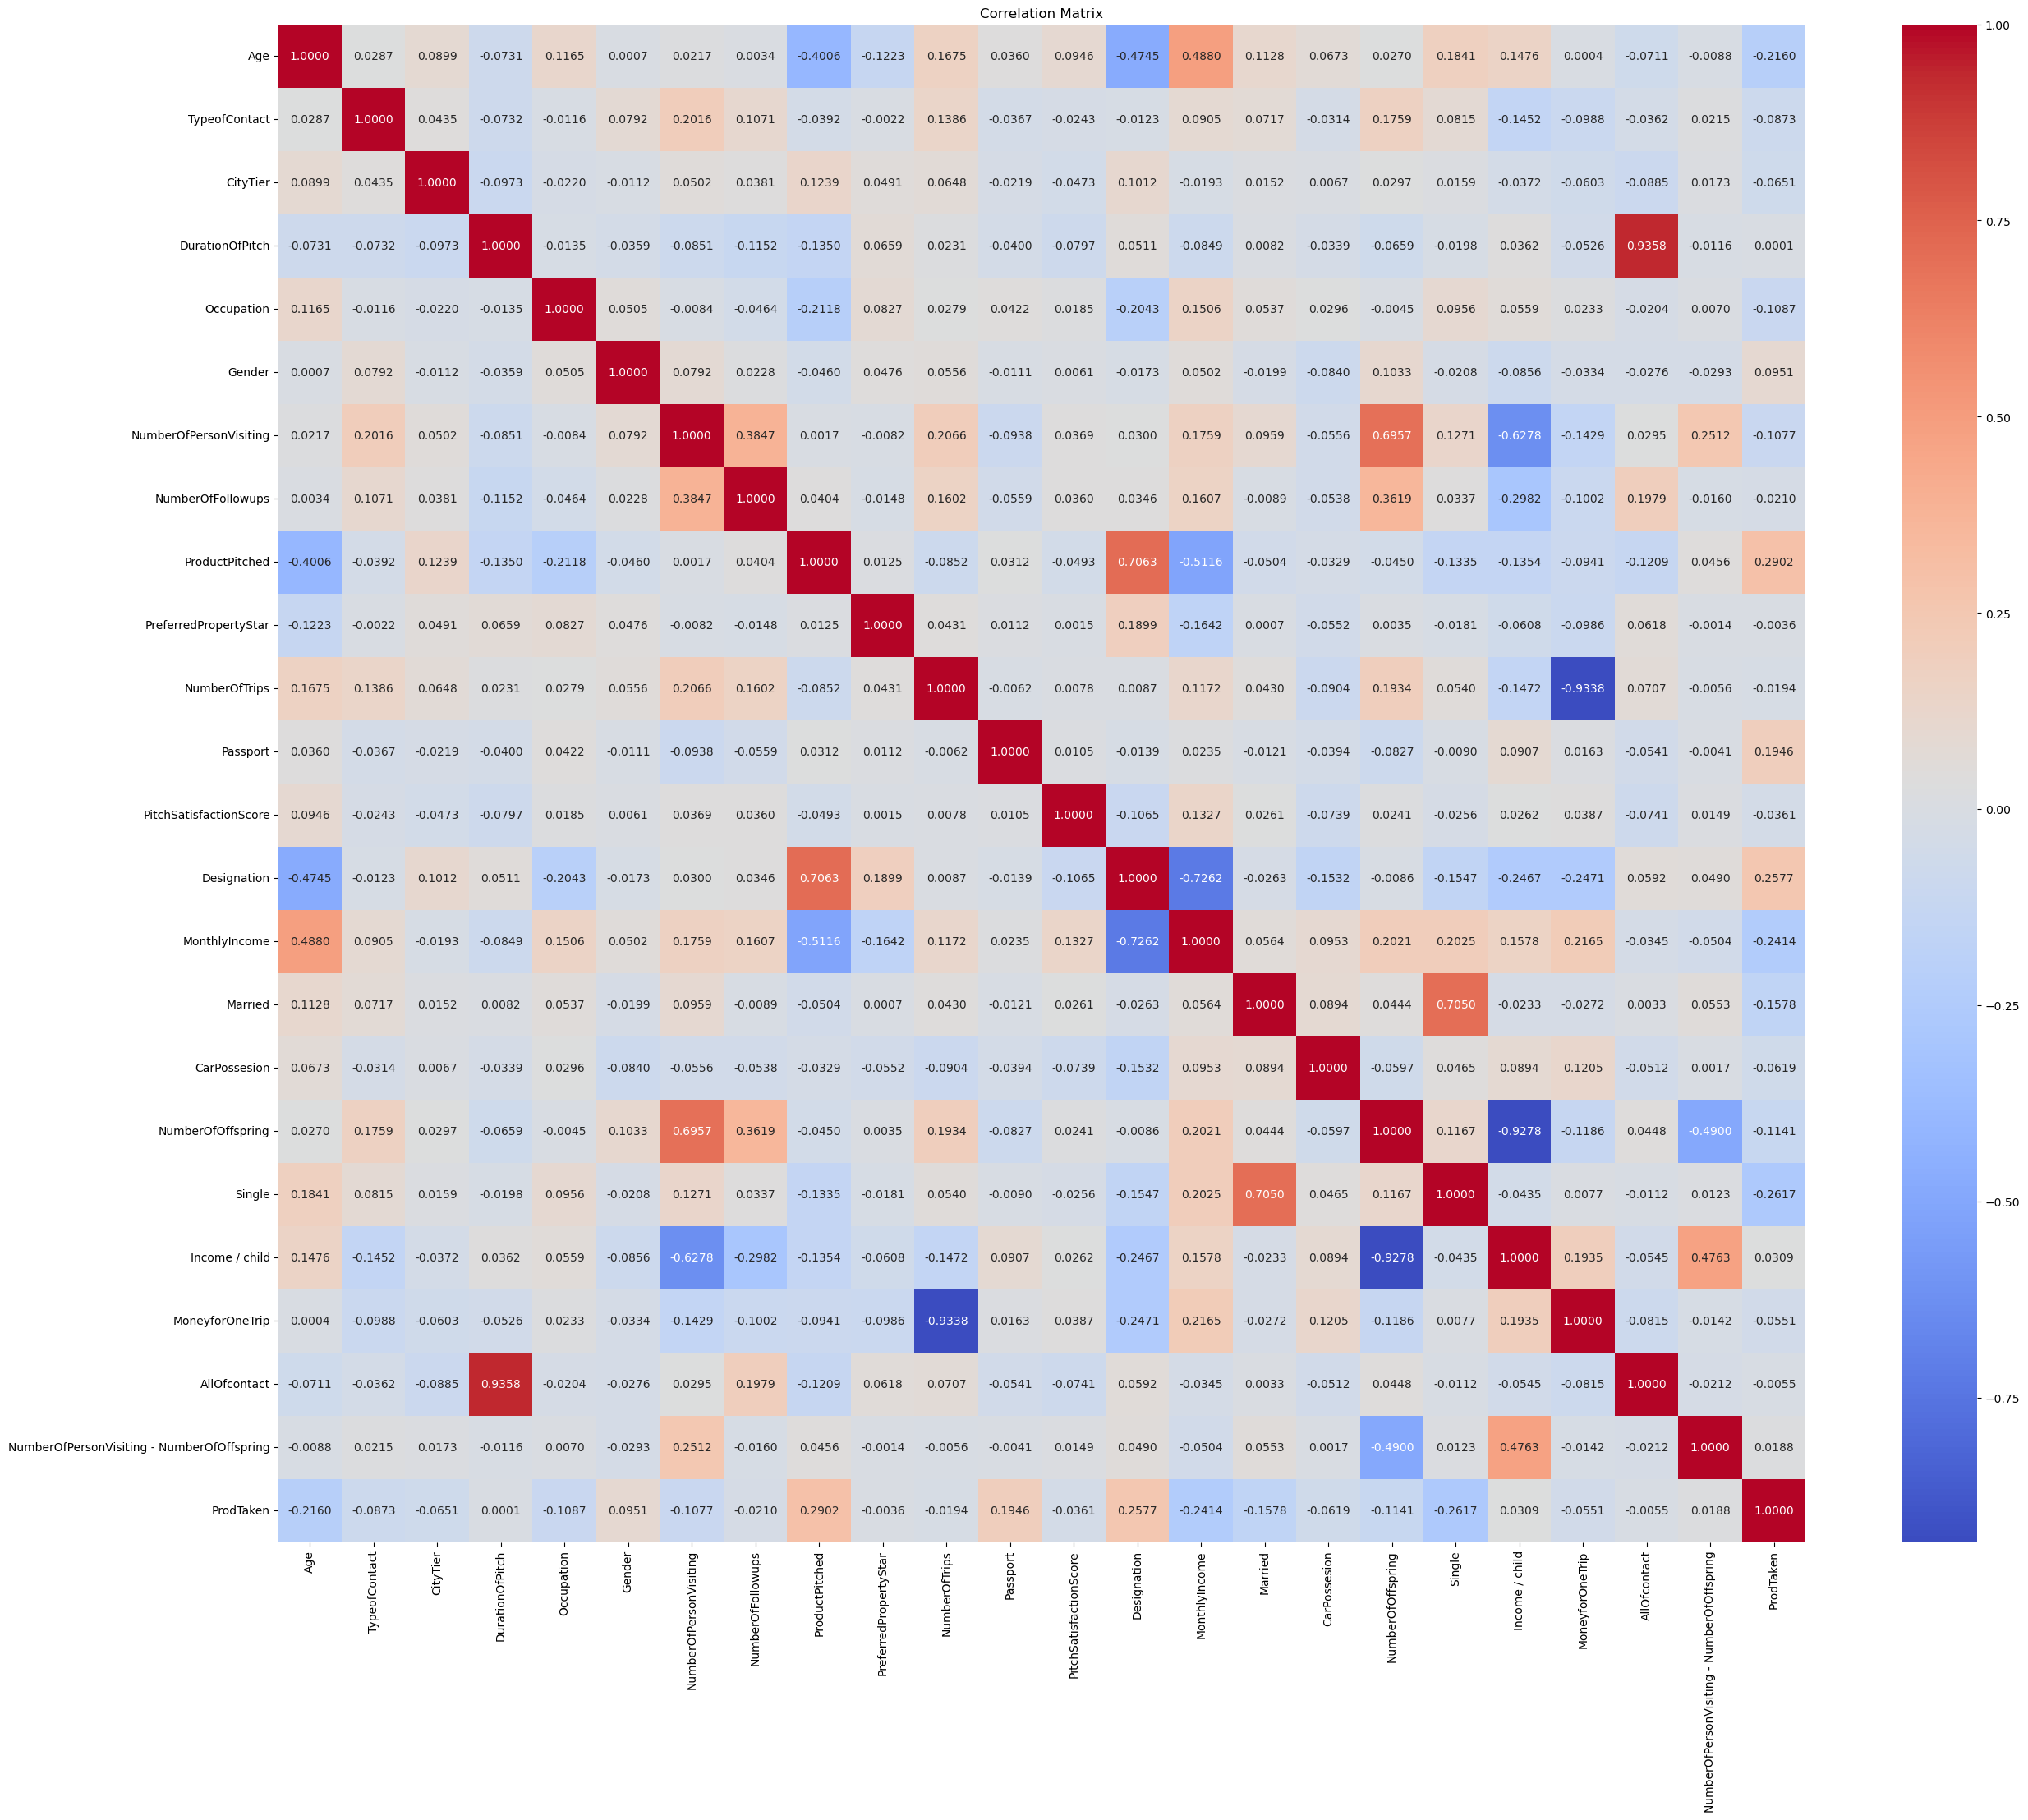

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
# 相関係数行列を計算
train1 = train1.dropna()
correlation_matrix = train1.corr(method='spearman')

plt.figure(figsize=(30, 24))
sns.heatmap(correlation_matrix, annot=True, fmt=".4f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [35]:
import matplotlib.pyplot as plt

def frequency_plot(feature, train, test):
    age_prod_taken_rate = train.groupby(feature)['ProdTaken'].mean()

    age_counts_tr = train[feature].value_counts().sort_index()
    age_counts_te = test[feature].value_counts().sort_index()

    plt.figure(figsize=(14, 12))

    plt.subplot(3, 1, 1)
    age_prod_taken_rate.plot(kind='bar', color='skyblue', alpha=0.7)
    plt.title(f'Train Percentage of ProdTaken = 1 by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Percentage')
    plt.grid(True)

    plt.subplot(3, 1, 2)
    age_counts_tr.plot(kind='bar', color='lightgreen', alpha=0.7)
    plt.title(f'Train Number of People by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    age_counts_te.plot(kind='bar', color='lightgreen', alpha=0.7)
    plt.title(f'Test Number of People by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def frequency_plot2(feature1, feature2, train, test):
    age_prod_taken_rate = train.groupby(feature)['ProdTaken'].mean()

    age_counts_tr = train[feature].value_counts().sort_index()
    age_counts_te = test[feature].value_counts().sort_index()

    plt.figure(figsize=(14, 12))

    plt.subplot(3, 1, 1)
    age_prod_taken_rate.plot(kind='bar', color='skyblue', alpha=0.7)
    plt.title(f'Train Percentage of ProdTaken = 1 by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Percentage')
    plt.grid(True)

    plt.subplot(3, 1, 2)
    age_counts_tr.plot(kind='bar', color='lightgreen', alpha=0.7)
    plt.title(f'Train Number of People by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    age_counts_te.plot(kind='bar', color='lightgreen', alpha=0.7)
    plt.title(f'Test Number of People by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
NumberOfPersonVisiting_NumberOfFollowups	NumberOfPersonVisiting_NumberOfTrips	NumberOfPersonVisiting_NumberOfOffspring	NumberOfFollowups_NumberOfPersonVisiting	NumberOfFollowups_NumberOfTrips	NumberOfFollowups_NumberOfOffspring	NumberOfTrips_NumberOfPersonVisiting	NumberOfTrips_NumberOfFollowups	NumberOfTrips_NumberOfOffspring	NumberOfOffspring_NumberOfPersonVisiting	NumberOfOffspring_NumberOfFollowups	NumberOfOffspring_NumberOfTrips

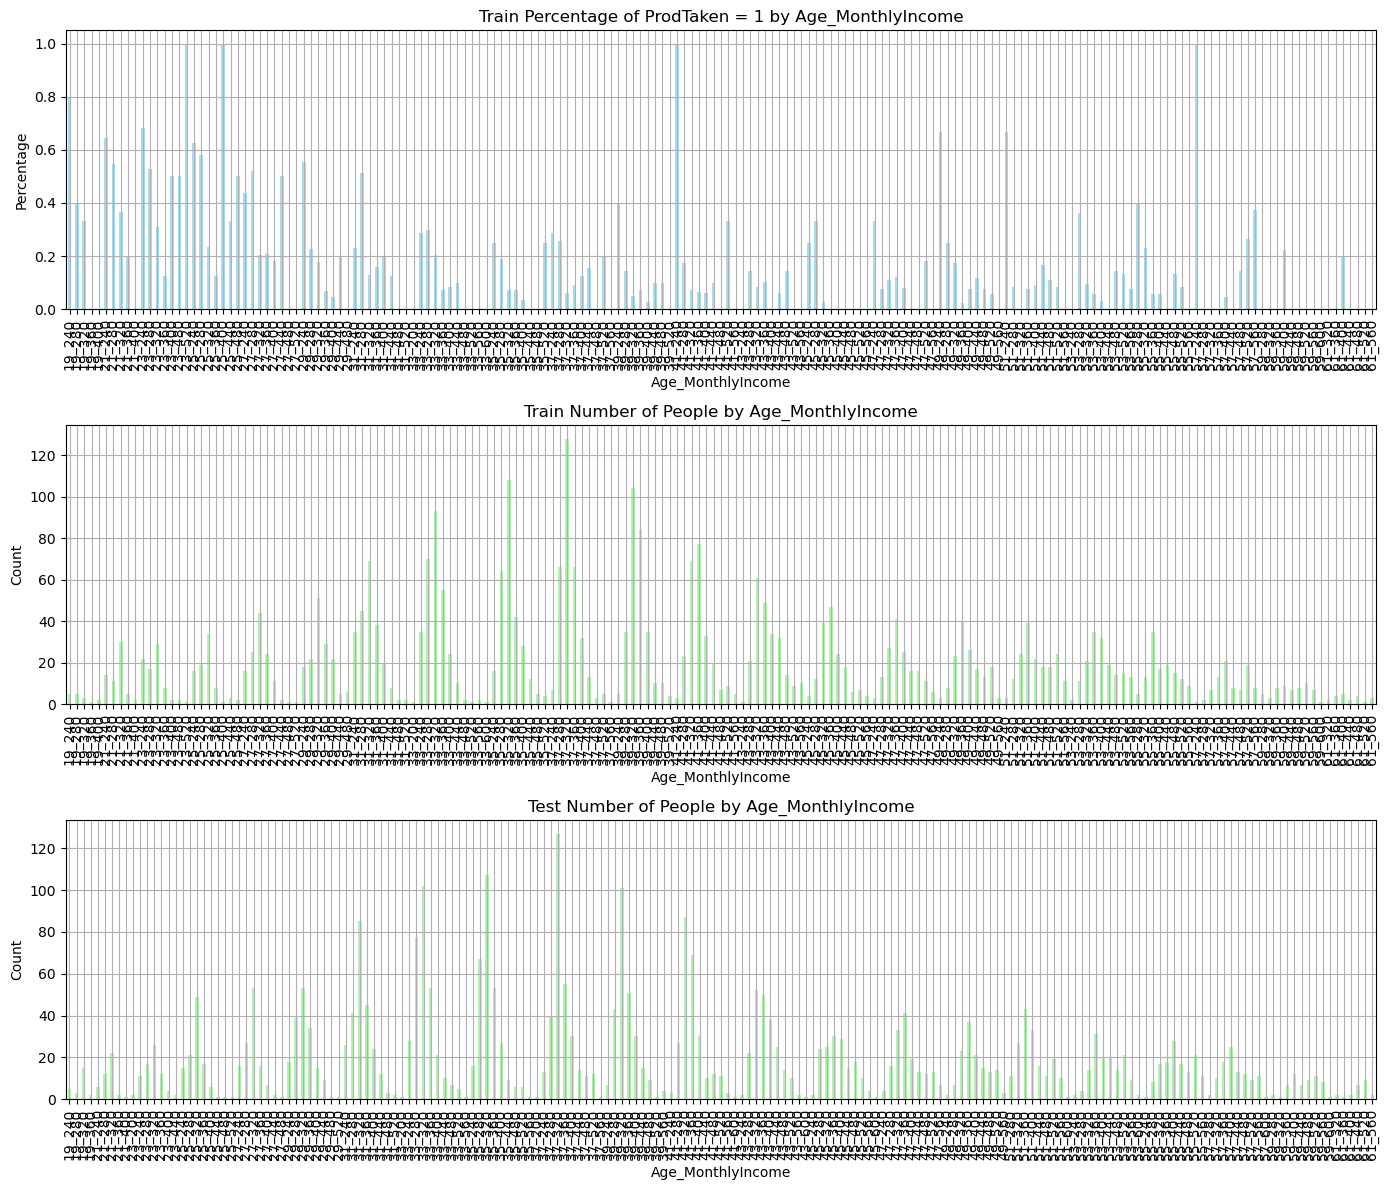

In [70]:
frequency_plot('Age_MonthlyIncome', train1, test1)
# NumberOfFollowups_NumberOfPersonVisiting
# NumberOfPersonVisiting_NumberOfFollowups

# ProductPitched_Designation	Designation_ProductPitched

C:\Users\yutak\AppData\Local\Temp\ipykernel_18072\4040341615.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_prod_taken_rate = train.groupby('IncomeBin')['ProdTaken'].mean()


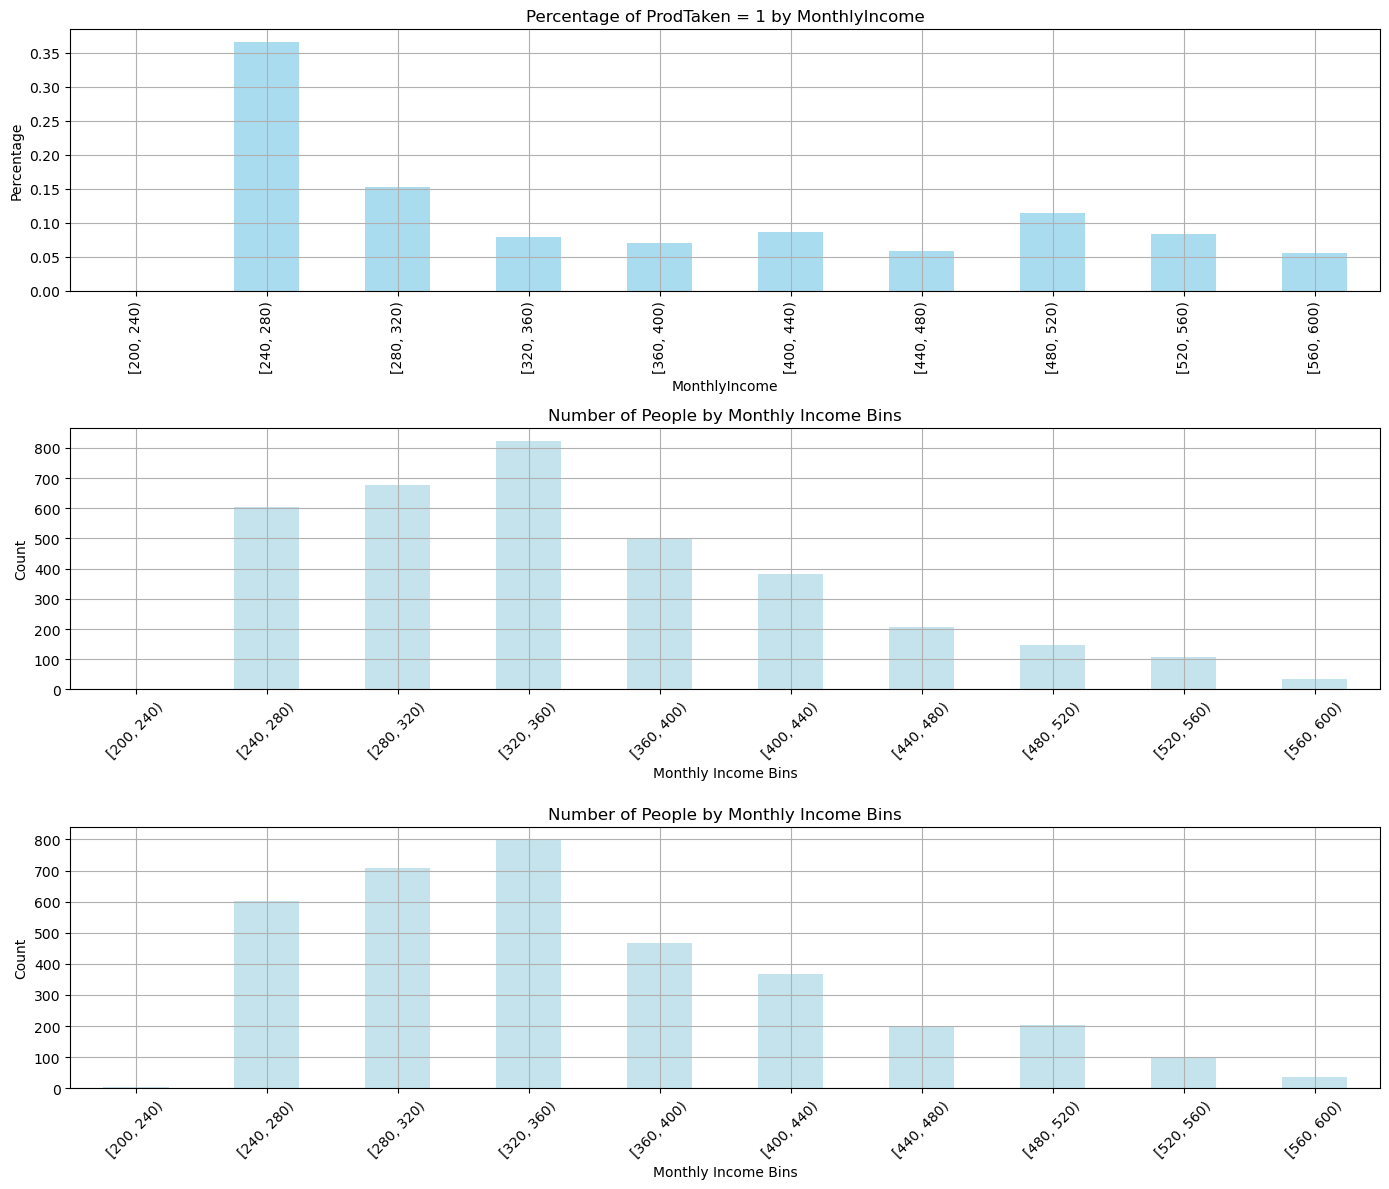

In [59]:
# MonthlyIncome
# 'MonthlyIncome' の値を階級に分ける
# ここでは例として100000円ごとの階級を作成
def frequency_plot_Income(train, test):
    width = 40
    bins = range(int(train['MonthlyIncome'].min()), int(train['MonthlyIncome'].max()) + width, width)
    train['IncomeBin'] = pd.cut(train['MonthlyIncome'], bins=bins, right=False)
    test['IncomeBin'] = pd.cut(test['MonthlyIncome'], bins=bins, right=False)
    
    # 階級ごとに 'ProdTaken' が 1 の割合を計算
    income_prod_taken_rate = train.groupby('IncomeBin')['ProdTaken'].mean()
    # 階級ごとの人数をカウント
    income_counts_tr = train['IncomeBin'].value_counts().sort_index()
    income_counts_te = test['IncomeBin'].value_counts().sort_index()
    
    # プロットの設定
    plt.figure(figsize=(14, 12))
    
    # 上のサブプロット：ProdTaken = 1 の割合
    plt.subplot(3, 1, 1)  # 2行1列のグリッドの最初の位置
    income_prod_taken_rate.plot(kind='bar', color='skyblue', alpha=0.7)
    plt.title('Percentage of ProdTaken = 1 by MonthlyIncome')
    plt.xlabel('MonthlyIncome')
    plt.ylabel('Percentage')
    plt.grid(True)
    
    # 下のサブプロット：階級ごとの収入の人数
    plt.subplot(3, 1, 2)  # 2行1列のグリッドの2番目の位置
    income_counts_tr.plot(kind='bar', color='lightblue', alpha=0.7)
    plt.title('Number of People by Monthly Income Bins')
    plt.xlabel('Monthly Income Bins')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    plt.subplot(3, 1, 3)  # 2行1列のグリッドの2番目の位置
    income_counts_te.plot(kind='bar', color='lightblue', alpha=0.7)
    plt.title('Number of People by Monthly Income Bins')
    plt.xlabel('Monthly Income Bins')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    
    plt.tight_layout()
    plt.show()
    
    train1 = train.drop(['IncomeBin'],axis=1)

frequency_plot_Income(train1, test1)

In [ ]:
def corration_plot(feature1, feature2, train):
    # feature1が数値とか
    # feature2が取る値少ないやつ

    # 階級幅を2分間隔で設定
    min_duration = train[feature1].min()
    max_duration = train[feature1].max()
    bins = list(range(int(min_duration), int(max_duration) + 1, 1))  # max + 1 で最後の階級を含める
    
    # feature2 の各値（1から5）ごとに別々のグラフを描く
    scores = sorted(train[feature2].unique())  # Unique scores
    
    plt.figure(figsize=(15, 10))  # 全体の図のサイズを設定
    
    for i, score in enumerate(scores, 1):
        plt.subplot(5, 2, i)  # 3行2列のサブプロット
        subset = train1[train1[feature2] == score]
        plt.hist(subset[feature1], bins=bins, alpha=0.7, color='lightblue')
        plt.title(f'{feature2}: {score}')
        plt.xlabel(feature1)
        plt.ylabel('Frequency')
        plt.tight_layout()  # グラフ同士が重ならないようにレイアウトを調整
    
    plt.show()

corration_plot('NumberOfOffspring', 'NumberOfPersonVisiting', train)

In [ ]:
['Age', 'DurationOfPitch', 'MonthlyIncome', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'NumberOfTrips', 'NumberOfOffspring']

In [ ]:
corration_plot('NumberOfPersonVisiting', 'NumberOfFollowups', train)
print('---------------------------------------')
corration_plot('NumberOfFollowups', 'NumberOfPersonVisiting', train)

In [ ]:
corration_plot('NumberOfPersonVisiting', 'NumberOfTrips', train)
print('---------------------------------------')
corration_plot('NumberOfTrips', 'NumberOfPersonVisiting', train)